In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [8]:
entidades = pd.read_csv("../data/bronze/entidades_proyecto.csv", sep=';')
# Se suprime la variable ID para la cosntrucción de modelos debido a que no se sabe si la etiqueta está bien asignada o no
entidades = entidades.drop(columns=['ID'])
entidades.head(2)

,NOMBRE,CODIGO,NIT
0,DEPARTAMENTO CUNDINAMARCASECRETARIA JURIDICA,702165101.0,899999114
1,DEPARTAMENTO CUNDINAMARCASECRETARIA MINAS ENER...,702262189.0,899999114


In [43]:
# Dado que los códigos se generan para cada registro, no se tomarán para el modelo debido a que estos se generan unicamente después del registro en alguna de las plataformas y el objetivo del proyecto
# es desarrollar el mecanismo para que se valide si ya existe antes de que sea registrado
entidades = entidades.drop(columns=['CODIGO'])
entidades.head(2)

,NOMBRE,NIT
0,DEPARTAMENTO CUNDINAMARCASECRETARIA JURIDICA,899999114
1,DEPARTAMENTO CUNDINAMARCASECRETARIA MINAS ENER...,899999114


In [44]:
# Dividir los datos en conjuntos de entrenamiento y prueba
entidades_train, entidades_test = train_test_split(entidades, test_size=0.2, random_state=42)

print('entidades_train', entidades_train.shape)
print('entidades_test', entidades_test.shape)

entidades_train (278, 2)
entidades_test (70, 2)


In [46]:
entidades_train['NOMBRE'] = entidades_train['NOMBRE'].astype(str)
entidades_train['NIT'] = entidades_train['NIT'].astype(str)

In [48]:
# Se crearán los vectorizadores de las tres columnas por separado debido a que
# el usuario podría elegir diligenciar solo uno de los campos del formulario

nombre_v = TfidfVectorizer()
nombre_train = nombre_v.fit_transform(entidades_train['NOMBRE'])
nombre_df = pd.DataFrame(nombre_train.toarray(), 
                        columns=nombre_v.get_feature_names_out())

nit_v = TfidfVectorizer()
nit_train = nit_v.fit_transform(entidades_train['NIT'])
nit_df = pd.DataFrame(nit_train.toarray(), 
                      columns=nit_v.get_feature_names_out())

# Se considera la union de las tres columnas por si el usuario decide 
# diligenciar todos los campos del formulario
entidades_v = pd.concat([nombre_df, nit_df], axis=1)

In [ ]:
# TODO: Aplicar estandarización de datos

In [50]:
print('nombre_df:', nombre_df.shape)
print('nit_df:', nit_df.shape)
print('entidades_v:', entidades_v.shape)

nombre_df: (278, 303)
nit_df: (278, 64)
entidades_v: (278, 367)


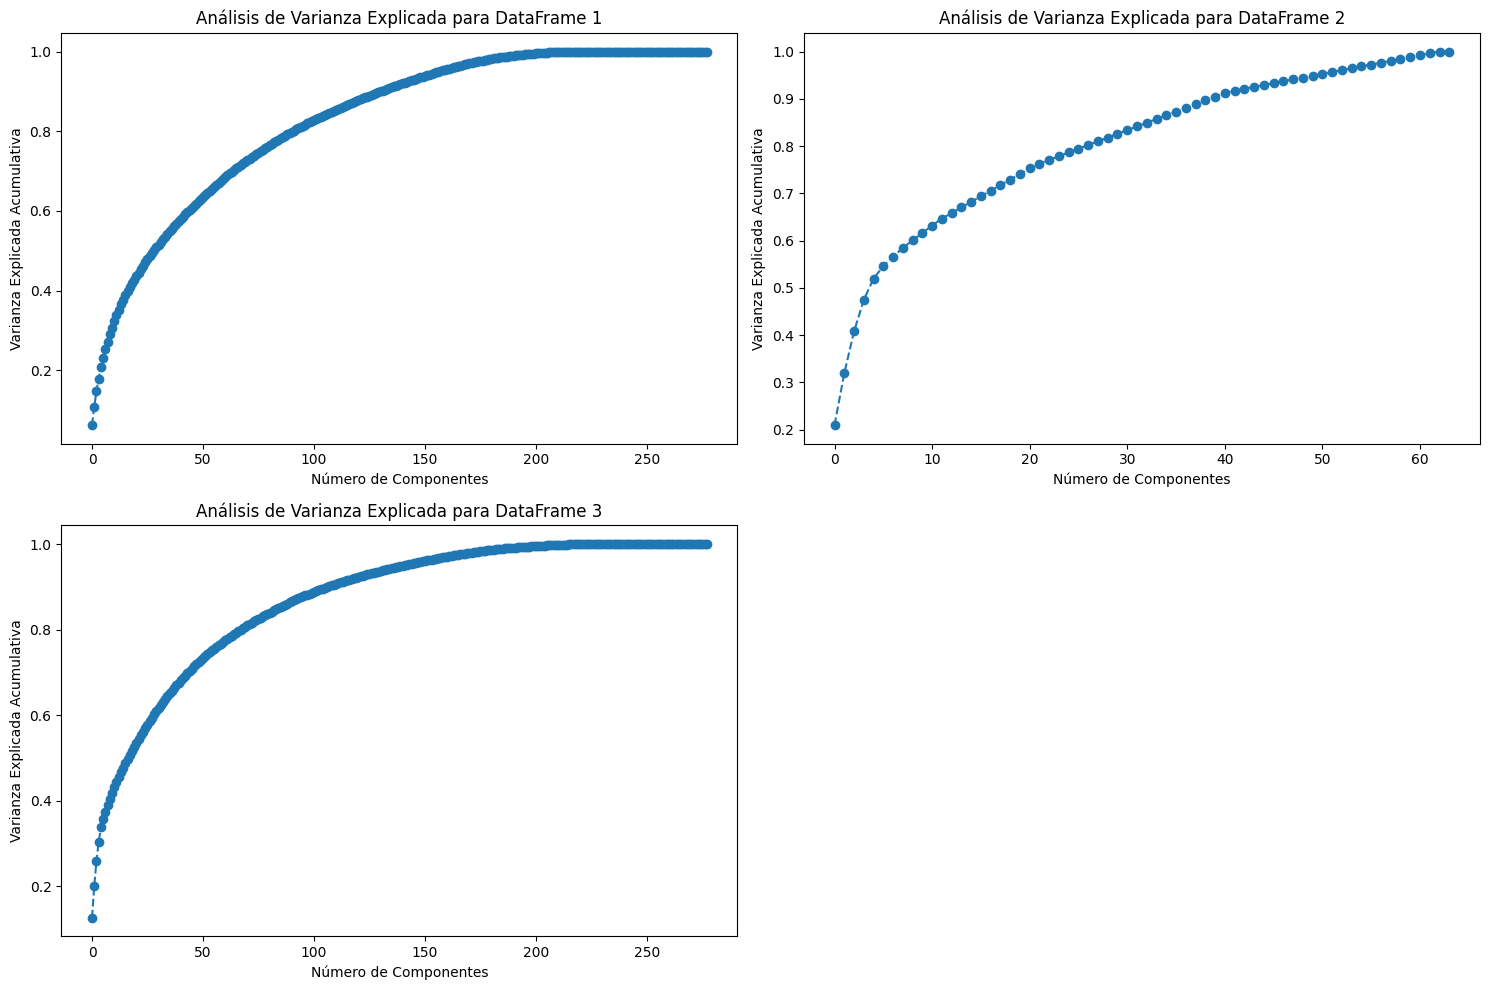

In [51]:
# Suponemos que estos son tus cuatro DataFrames
dataframes = [nombre_df, nit_df, entidades_v]

# Configuramos el tamaño de la figura para visualizar todas las gráficas adecuadamente
plt.figure(figsize=(15, 10))

# Iterar sobre cada DataFrame y aplicar PCA
for i, nombre_df in enumerate(dataframes, 1):
    # Aplicar PCA
    pca = PCA().fit(nombre_df)
    
    # Calcular la varianza explicada acumulativa
    varianza_explicada_cumulativa = np.cumsum(pca.explained_variance_ratio_)
    
    # Crear un subplot para cada DataFrame
    plt.subplot(2, 2, i)
    plt.plot(varianza_explicada_cumulativa, marker='o', linestyle='--')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza Explicada Acumulativa')
    plt.title(f'Análisis de Varianza Explicada para DataFrame {i}')

# Mostrar todas las gráficas
plt.tight_layout()
plt.show()

In [52]:
# Análisis para la cantidad de componentes principales por nombre, nit y registros de nombres y nits
# Nombres: Para este caso es notable la dificultad para identificar el codo de la gráfica, motivo por el cuál buscaremos reflejar por un 75% de la varianza. Esto se logra con aproximadamente 70 componentes principales
# Nits: El más sencillo de las tres gráficas. Se observa que el codo se alcanza en los primeros 5 componentes principales. Sin embargo, para explicar el 75% de la varianza serán necesarios 20 componentes principales.
# Nombres y nits: Si bien se logra apreciar un comportamiento como en el caso de los nombres, se observa que la varianza del 75% se logra alcanzar con 50 componentes principales aproximadamente. De modo que:

# Creación y uso de los componentes principales por conjunto de datos
pca_nombres = PCA(n_components=70)
pc_nombres = pca_nombres.fit_transform(nombre_df)

pca_nits = PCA(n_components=20)
pc_nits = pca_nits.fit_transform(nit_df)

pca_entidades = PCA(n_components=50)
pc_entidades = pca_entidades.fit_transform(entidades_v)

# Paso a dataframes para el análisis posterior
nombres_pca_df = pd.DataFrame(data = pc_nombres)
nits_pca_df = pd.DataFrame(data = pc_nits)
entidades_pca_df = pd.DataFrame(data = pc_entidades)

print('nombres_pca_df:', nombres_pca_df.shape)
print('nits_pca_df:', nits_pca_df.shape)
print('entidades_pca_df:', entidades_pca_df.shape)

nombres_pca_df: (278, 70)
nits_pca_df: (278, 20)
entidades_pca_df: (278, 50)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (30) found smaller than n_clusters (31). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (31) found smaller than n_clusters (33). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (33) found smaller than n_clusters (34). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (33) found smaller than n_clusters (

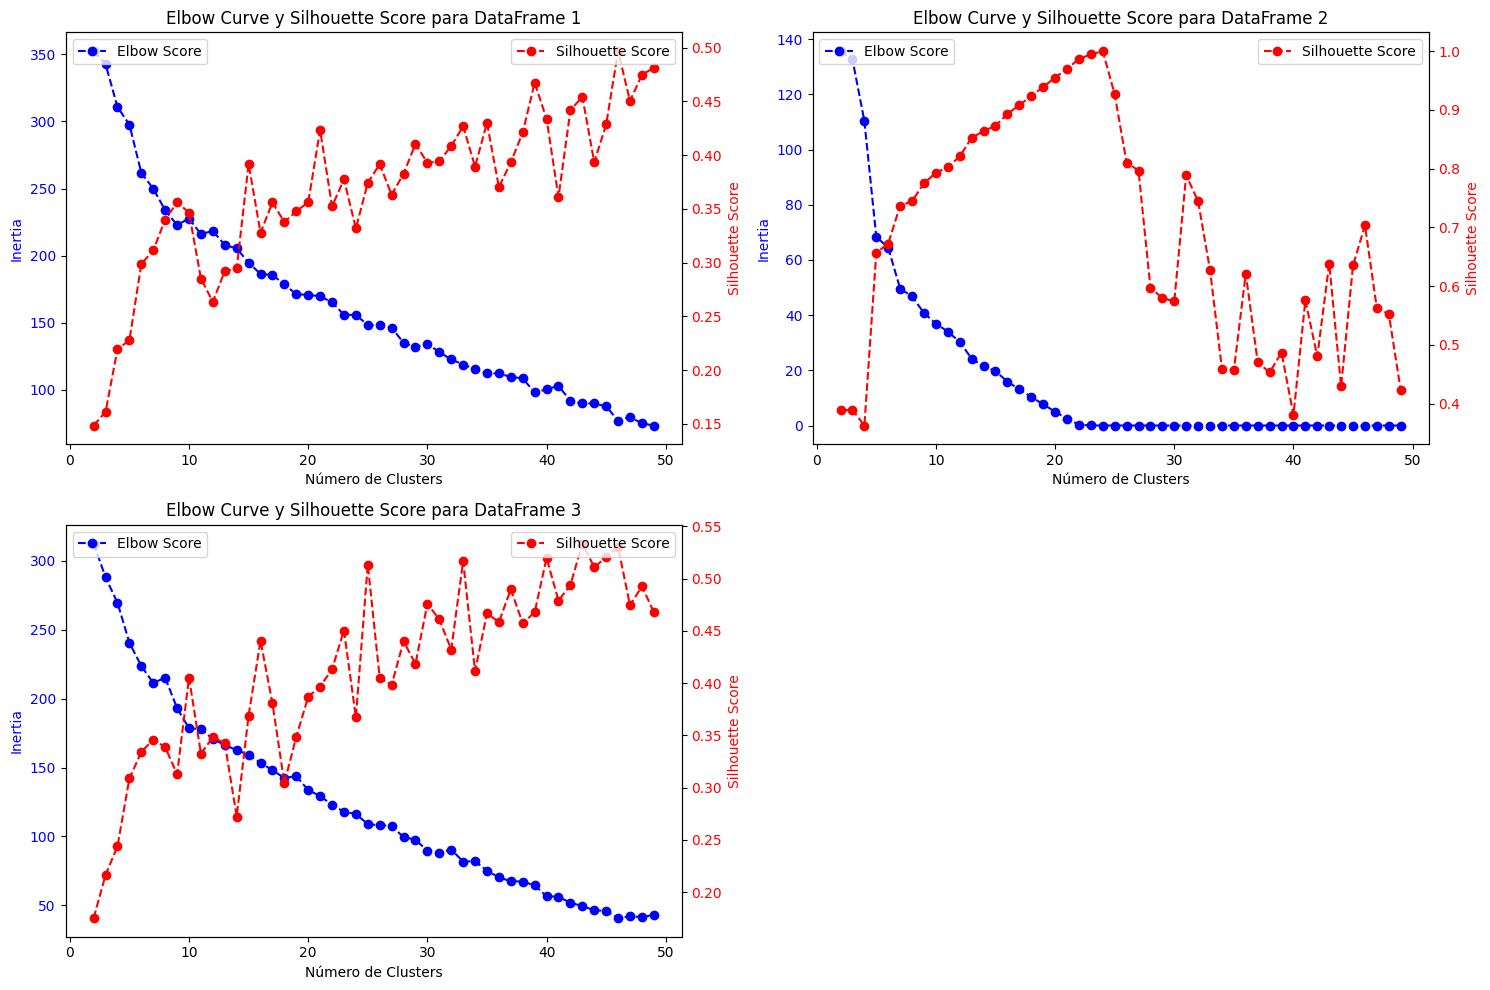

In [68]:
# Suponemos que estos son tus tres DataFrames
dataframes = [nombres_pca_df, nits_pca_df, entidades_pca_df]
Nc = range(2, 50)  # El score de silueta no se puede calcular para Nc = 1

# Configuramos el tamaño de la figura para visualizar todas las gráficas adecuadamente
plt.figure(figsize=(15, 10))

# Iterar sobre cada DataFrame y aplicar PCA
for i, df in enumerate(dataframes, 1):
    scores = []
    sil_scores = []
    kmeans = [KMeans(n_clusters=num_clusters) for num_clusters in Nc]
    
    for model in kmeans:
        model.fit(df)
        scores.append(-model.score(df))  # Usamos el negativo del score porque KMeans minimiza la inercia
        labels = model.labels_
        sil_score = silhouette_score(df, labels)
        sil_scores.append(sil_score)
    
    # Crear un subplot para cada DataFrame
    ax = plt.subplot(2, 2, i)
    ax.plot(Nc, scores, marker='o', linestyle='--', color='blue', label='Elbow Score')
    ax.set_xlabel('Número de Clusters')
    ax.set_ylabel('Inertia', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f'Elbow Curve y Silhouette Score para DataFrame {i}')

    # Crear eje y secundario para los scores de silueta
    ax2 = ax.twinx()
    ax2.plot(Nc, sil_scores, marker='o', linestyle='--', color='red', label='Silhouette Score')
    ax2.set_ylabel('Silhouette Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Añadir leyendas
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Mostrar todas las gráficas
plt.tight_layout()
plt.show()

In [22]:
tfidf_test.toarray()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.3861804, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])